In [1]:
import time
from pathlib import Path

import dfmtoolbox as ddm
import dfmtoolbox.window as window
import dfmtoolbox.mask as mask
import numpy as np
import matplotlib.pyplot as plt
from dfmtoolbox.utils import tiff_to_numpy
from matplotlib.colors import LogNorm

%matplotlib inline

In [3]:
# read image files
im_path = Path("../tests/test-imgs/confocal/")
images = np.array([tiff_to_numpy(im) for im in sorted(im_path.iterdir()) if im.name.endswith(".tif")])
images.shape

(1024, 256, 256)

In [3]:
# set pixel size & difference between 2 consecutive images
## see readme.txt in tests/test-imgs/
pixel_size = 0.123  # µm/px
dt = 43e-3  # s 

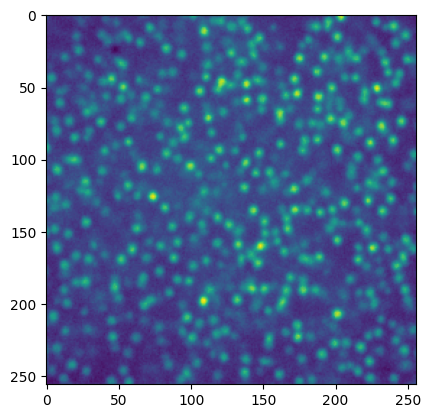

In [4]:
# check a sample image
test_im = 100
plt.imshow(images[test_im])

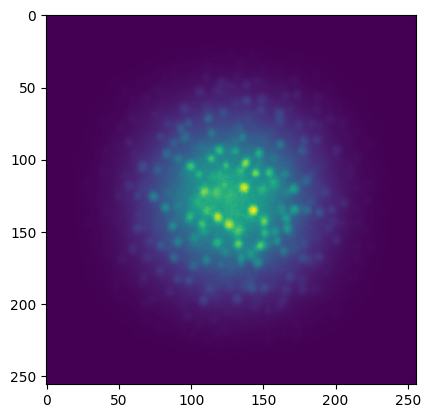

In [5]:
# in case you'd like to apply a standard windowing function to the images, you can do it now:
bh_window = window.blackman_harris(images.shape)

plt.imshow(bh_window * images[test_im])

# uncomment the line below to apply the window to all images
# images = bh_window * images

In [6]:
# setup lags
lags = np.arange(1, len(images)//2)  # lag times in frames up to 50% of the overall movie length
actual_time = lags * dt

### C++ backend

In [7]:
start = time.perf_counter()
structure_function = ddm.ddm(images, lags, core="cpp", mode="fft")

print(f"Duration: [{time.perf_counter()-start:.2f}] seconds")

Duration: [3.79] seconds


### python backend

In [15]:
start = time.perf_counter()
structure_function_py = ddm.ddm(images, lags, core="py", mode="fft")

print(f"Duration: [{time.perf_counter()-start:.2f}] seconds")

Duration: [38.121451702998456] seconds


In [8]:
structure_function.shape

(511, 256, 256)

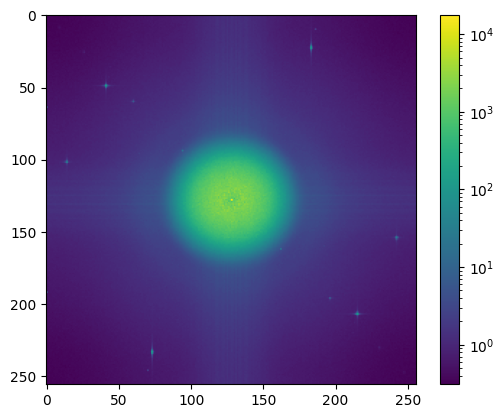

In [9]:
# investigate the structure function
plt.imshow(structure_function[test_im], norm=LogNorm())
plt.colorbar()

In [10]:
# now, to azimuthally average the structure function, allwhile excluding the central cross:
## first we need the mask for the central cross:
shape = images.shape[1:]
cc_mask = mask.central_cross_mask(shape)

## and then hand it to the azimuthal average function
avg_structure_function, k, bins = ddm.azimuthal_average(structure_function, mask=cc_mask, bins=30)

In [11]:
# get q vectors from k by dividing by pixel size
q = k / pixel_size

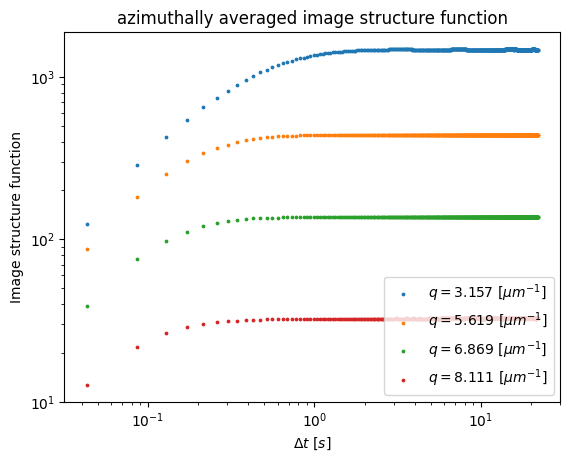

In [16]:
test_k = [3, 5, 6, 7]
for tk in test_k:    
    plt.scatter(actual_time, avg_structure_function[tk], marker="o", s=3, label="$q={:.3f}\ [\mu m^{{-1}}]$".format(q[tk]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\Delta t\ [s]$")
plt.ylabel("Image structure function")
plt.title("azimuthally averaged image structure function")
plt.legend(loc=4)

## Fitting

In [18]:
from dfmtoolbox.fit import simple_structure_function, fit

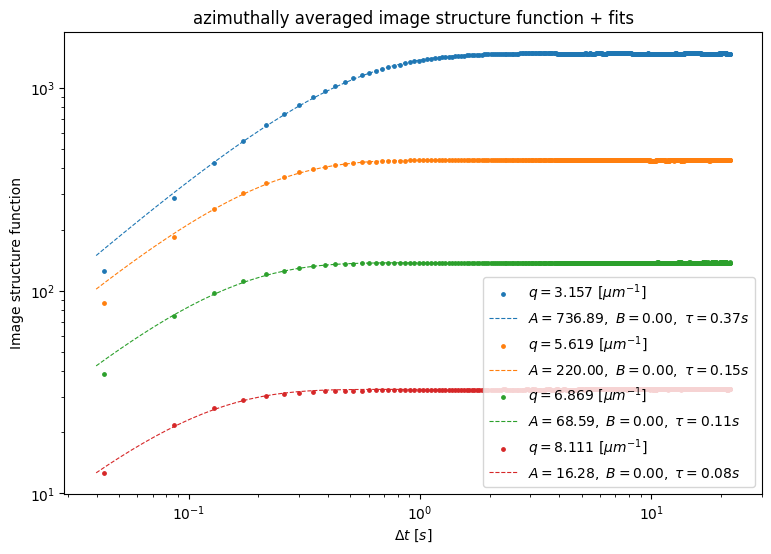

In [23]:
# plot setup
test_k = [3, 5, 6, 7]
colors = ["tab:" + col for col in ["blue", "orange", "green", "red"]]
fit_time = np.logspace(-1.4, 1.1)
labelstr = r"$A = {A:.2f},\ B = {B:.2f},\ \tau = {tau:.2f}s$"

fig = plt.figure(figsize=(9, 6))
for tk, color in zip(test_k, colors):    
    # fit for the given fixed index/k
    result = fit(simple_structure_function, xdata=actual_time, ydata=avg_structure_function[tk])
    # plot original data
    plt.scatter(actual_time, avg_structure_function[tk], marker="o", s=6, color=color, label="$q={:.3f}\ [\mu m^{{-1}}]$".format(q[tk]))
    # and the fit
    plt.plot(fit_time, simple_structure_function.eval(**result.best_values, dt=fit_time), color=color, linestyle="--", linewidth=0.8, label=labelstr.format(**result.best_values))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\Delta t\ [s]$")
plt.ylabel("Image structure function")
plt.title("azimuthally averaged image structure function + fits")
plt.legend(loc=4)